

#  **E-Waste Image Classification Using EfficientNetV2B0**



##  Problem Statement and Description

E-waste (electronic waste) is rapidly becoming a serious environmental and health issue around the world. Proper sorting and categorization of e-waste is essential for efficient recycling and disposal, but manual classification is error-prone and labor-intensive.

This project aims to build an automated e-waste classification system using artificial intelligence and machine learning. By training a deep learning model on images of different types of e-waste, we can identify and categorize them accurately.

###  Goal:
Use image classification with EfficientNetV2B0 to classify e-waste into 10 distinct categories to support better sorting and recycling automation.




In [5]:
import zipfile
import os

zip_path = "/content/data.zip"         # path to your ZIP file
extract_dir = "/content/data01"          # target folder to extract

# Create the folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction complete. Files are in:", extract_dir)


✅ Extraction complete. Files are in: /content/data01


In [6]:
# Install TensorFlow package
!pip install tensorflow

In [7]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations



###The zipfile is extracted to data01/data directory and test data,train data and validation data are stored in testpath,trainpath, and validpath respectively

In [8]:
testpath= r'/content/data01/data/test'
trainpath= r'/content/data01/data/train'
validpath = r'/content/data01/data/val'

In [35]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [51]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [37]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [38]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


##An example data from each class is displayed below

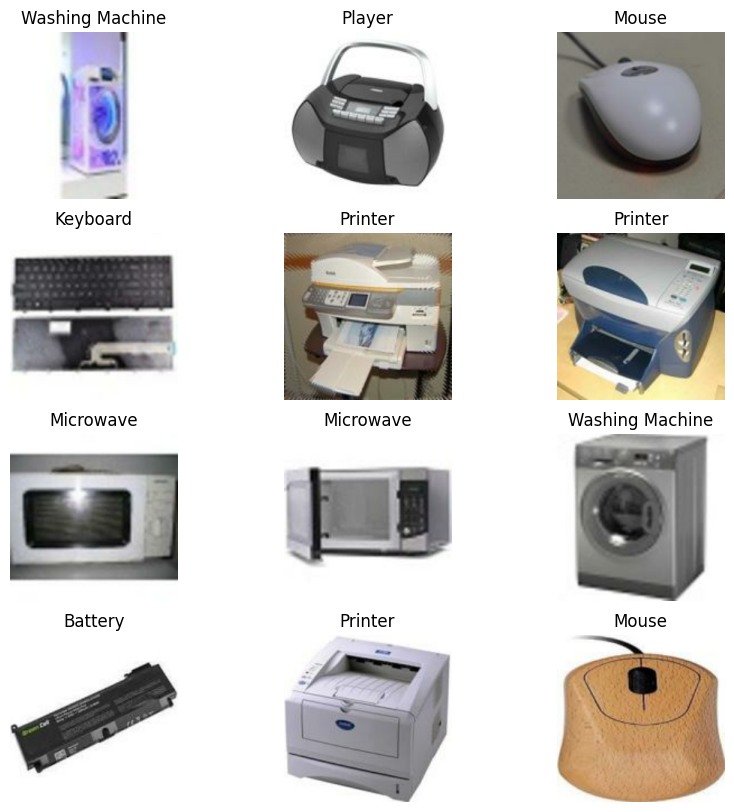

In [39]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


##The plot_class_distribution function aims to display the data distribution over each class

In [15]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


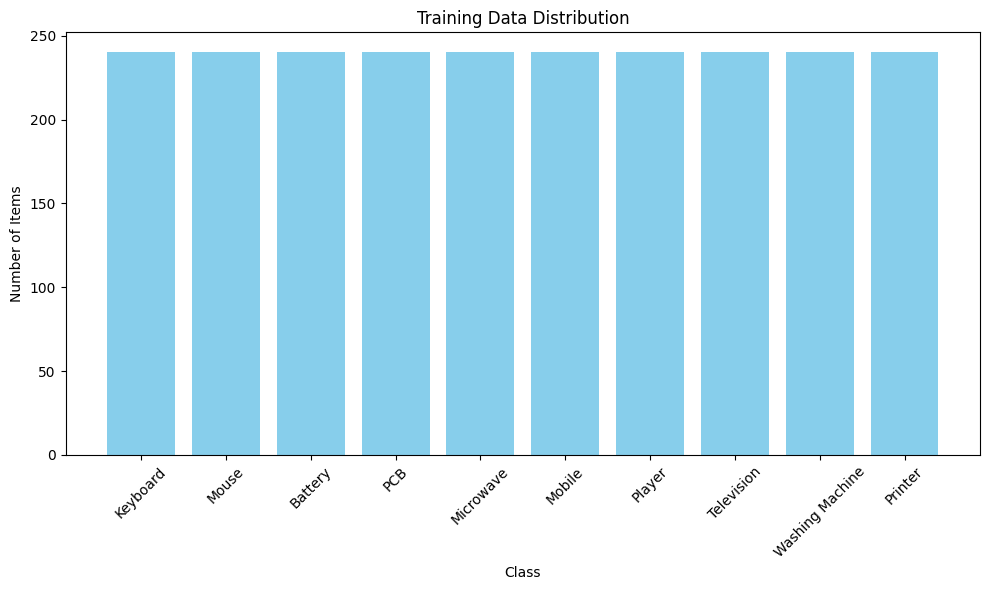

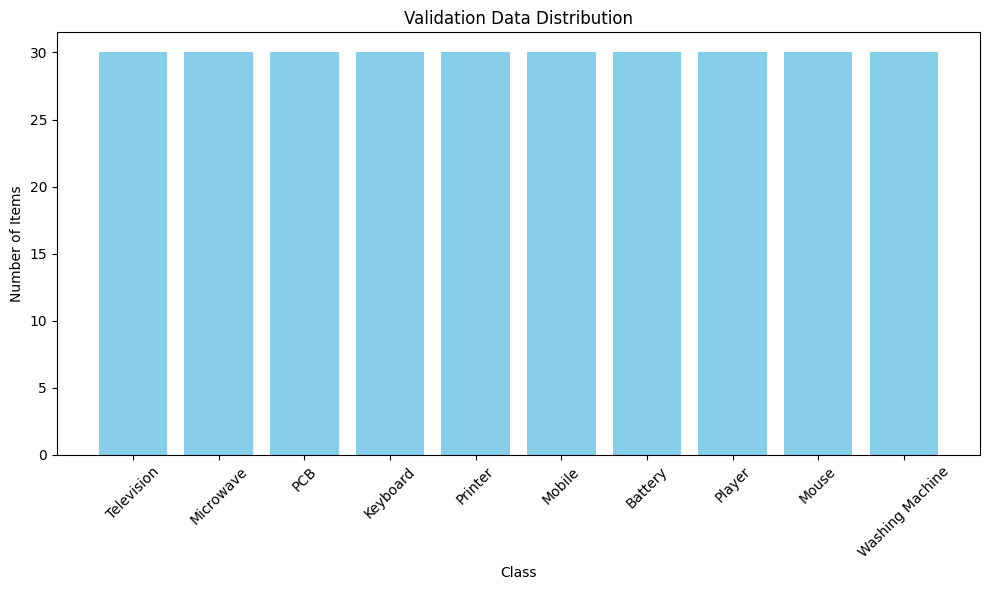

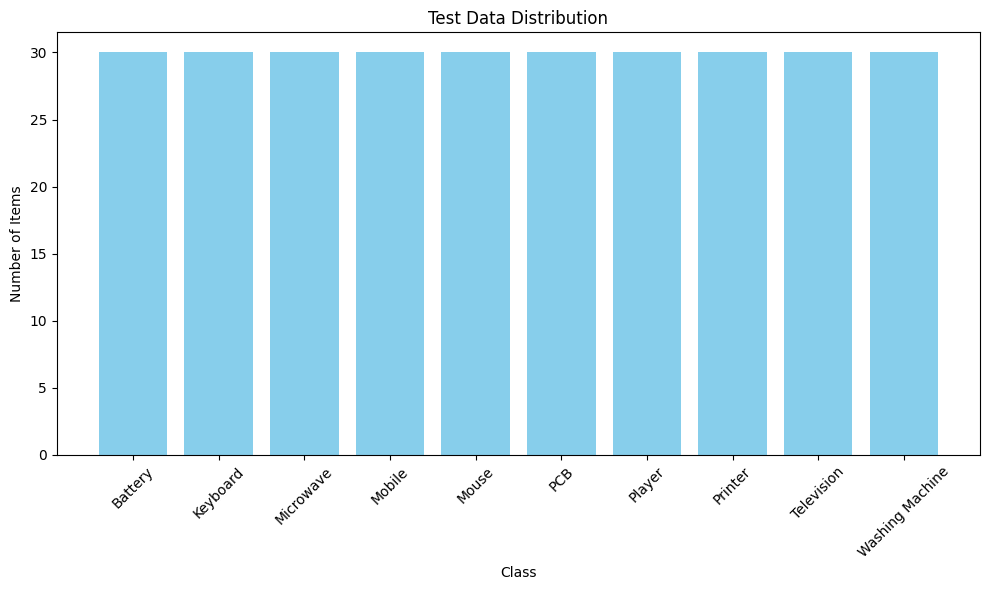

In [16]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

])
#tf.keras.layers.RandomContrast(0.1),

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Image size
image_size = (128, 128)

# Load base model
base_model = EfficientNetB0(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze first 100 layers for transfer learning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=image_size + (3,)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax',
        kernel_regularizer=regularizers.l2(0.001))
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,067,501 (15.52 MB)

 Trainable params: 3,855,718 (14.71 MB)

 Non-trainable params: 211,783 (827.28 KB)

In [40]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

datatrain = datatrain.map(lambda x, y: (preprocess_input(x), y))
datavalid = datavalid.map(lambda x, y: (preprocess_input(x), y))
#datatest  = datatest.map(lambda x, y: (preprocess_input(x), y))
AUTOTUNE = tf.data.AUTOTUNE
datatrain = datatrain.cache().prefetch(buffer_size=AUTOTUNE)
datavalid = datavalid.cache().prefetch(buffer_size=AUTOTUNE)
#datatest  = datatest.cache().prefetch(buffer_size=AUTOTUNE)


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Image size
image_size = (224, 224)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Load base model
base_model = MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze some initial layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build model
model = models.Sequential([
    layers.Input(shape=image_size + (3,)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125,002 (11.92 MB)

 Trainable params: 2,938,474 (11.21 MB)

 Non-trainable params: 186,528 (728.62 KB)

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_accuracy"
)


lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

In [33]:
import tensorflow.keras.backend as K
K.clear_session()


In [43]:
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=15,
    callbacks=[early_stop, checkpoint_cb]
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.1617 - loss: 2.8163 - val_accuracy: 0.5533 - val_loss: 1.3896
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5187 - loss: 1.4209 - val_accuracy: 0.7700 - val_loss: 0.7497
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.7026 - loss: 0.9062 - val_accuracy: 0.8500 - val_loss: 0.5030
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8092 - loss: 0.6391 - val_accuracy: 0.8967 - val_loss: 0.3940
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8389 - loss: 0.5170 - val_accuracy: 0.9133 - val_loss: 0.3266
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8844 - loss: 0.4072 - val_accuracy: 0.9333 - val_loss: 0.2800
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9004 - loss: 0.3433 - val_accuracy: 0.9433 - val_loss: 0.2367
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9224 - loss: 0.2693 - val_accuracy: 

In [53]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001,952 (34.34 MB)

 Trainable params: 2,938,474 (11.21 MB)

 Non-trainable params: 186,528 (728.62 KB)

 Optimizer params: 5,876,950 (22.42 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [44]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']    # Validation loss

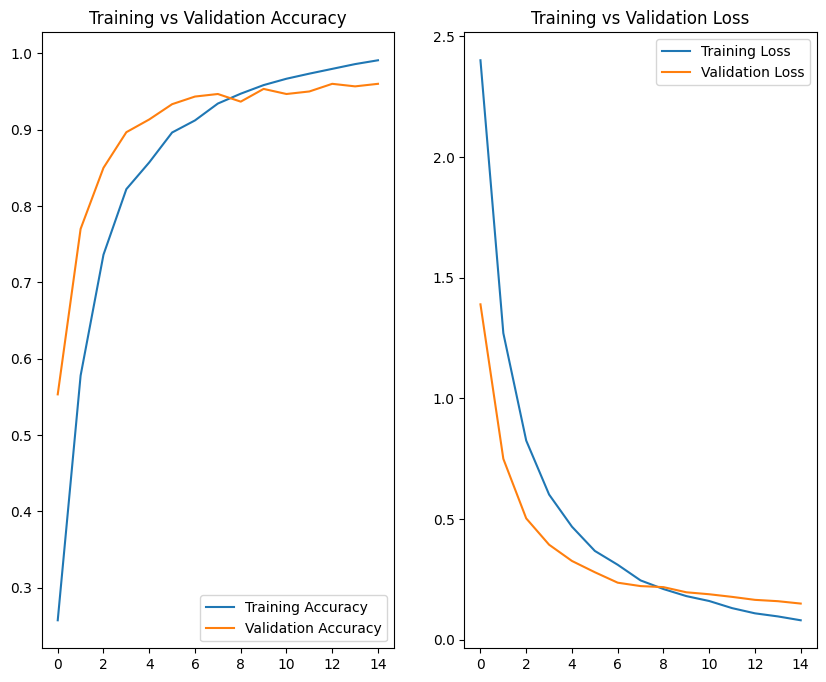

In [45]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [46]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9581 - loss: 0.1647
Test accuracy is0.9500, Test loss is 0.1878


In [47]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step
[[28  0  0  0  0  1  1  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 1  0  0 28  0  0  0  0  1  0]
 [ 0  0  1  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 0  0  1  0  0  0 29  0  0  0]
 [ 0  0  2  0  0  0  2 26  0  0]
 [ 0  0  3  0  0  0  0  1 26  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       1.00      1.00      1.00        30
           2       0.81      1.00      0.90        30
           3       1.00      0.93      0.97        30
           4       1.00      0.97      0.98        30
           5       0.97      0.97      0.97        30
           6       0.88      0.97      0.92        30
           7       0.96      0.87      0.91        30
           8       0.96      0.87      0.91        30
           9       1.00      1.00      1.00        30

    accuracy                    

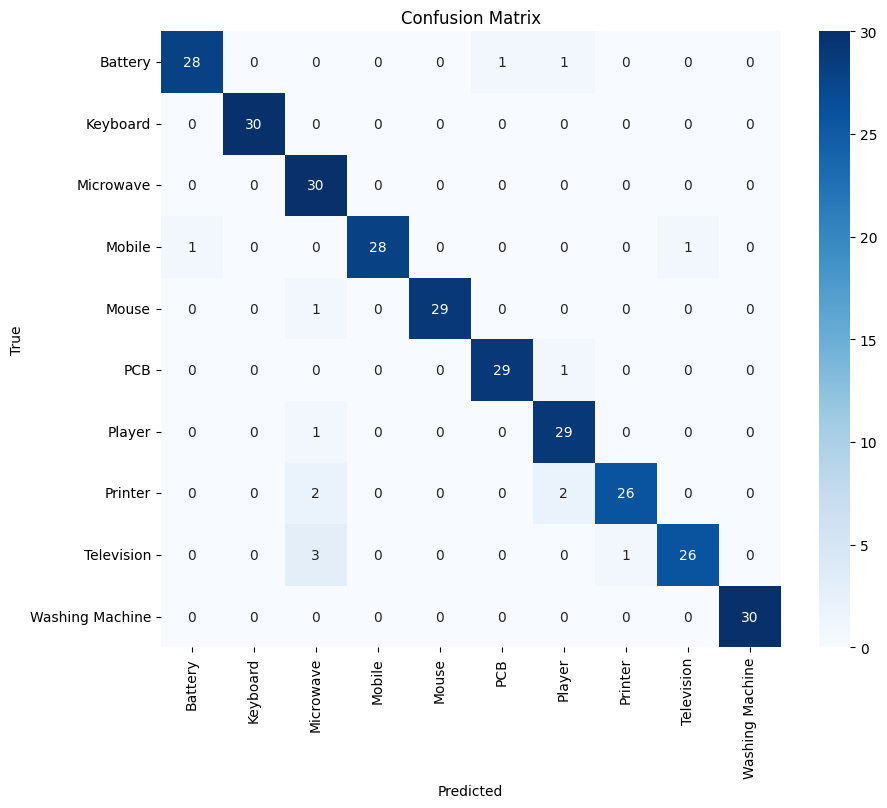

In [48]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


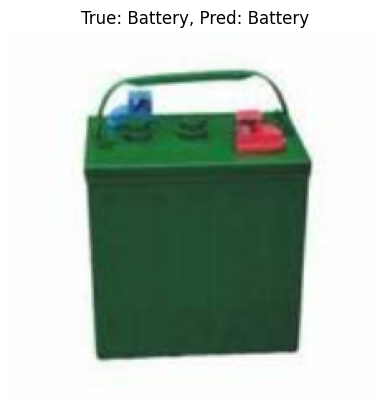

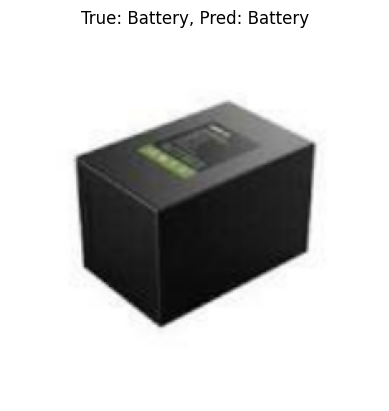

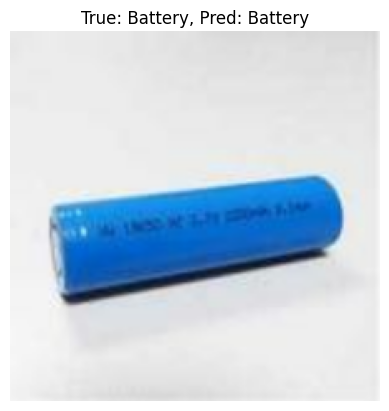

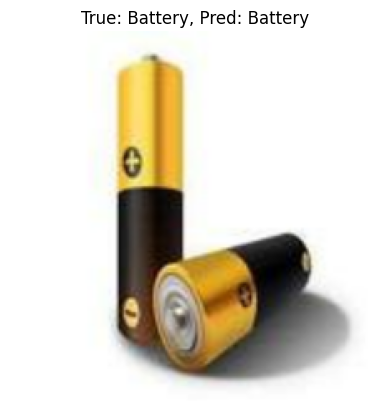

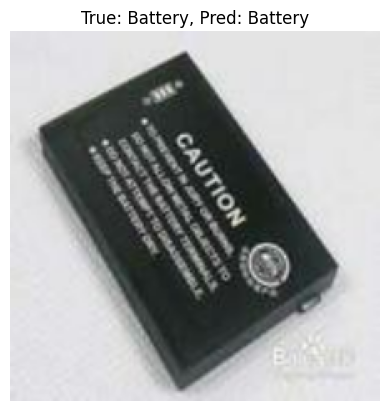

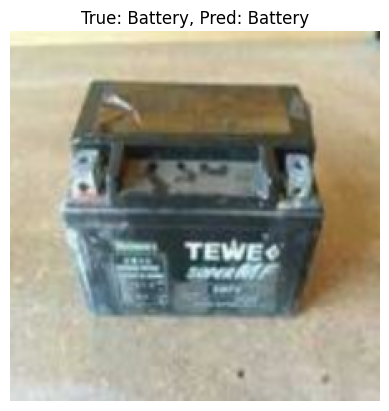

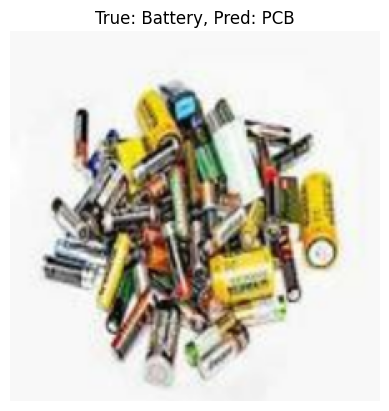

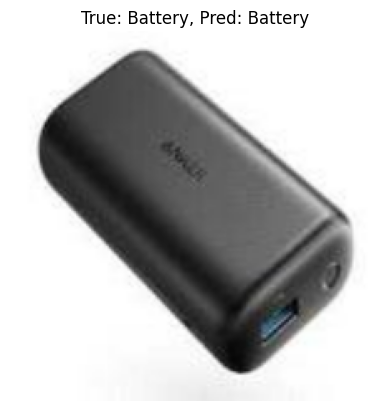

In [52]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [54]:
!pip install gradio

In [ ]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [ ]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


In [6]:
!pip install gTTS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [2]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tempfile
import os

# Class and instruction dictionaries
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse',
               'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

recycling_instructions = {
    "Battery": "Take to a hazardous waste center. Avoid regular trash disposal.",
    "Keyboard": "Can be disassembled. Plastic and circuit board parts are recyclable.",
    "Microwave": "Contains electronic and metal parts. Drop at an e-waste recycling facility.",
    "Mobile": "Backup data and remove SIM. Recycle via authorized mobile e-waste programs.",
    "Mouse": "Recyclable. Drop off at electronics recycling bins.",
    "PCB": "Contains hazardous materials. Must be handled by certified recyclers.",
    "Player": "Recyclable as electronic scrap. Remove batteries if present.",
    "Printer": "Remove ink cartridges and recycle at e-waste centers.",
    "Television": "CRTs/LEDs have toxic elements. Hand over to certified recycling units.",
    "Washing Machine": "Recycle metal drum and motor components at appliance scrap yards.",
}

impact_table = {
    "Battery": 1.8,
    "Keyboard": 0.5,
    "Microwave": 6.0,
    "Mobile": 8.0,
    "Mouse": 0.4,
    "PCB": 2.5,
    "Player": 1.0,
    "Printer": 4.0,
    "Television": 12.0,
    "Washing Machine": 10.0,
}

# Load model
model = tf.keras.models.load_model("/content/best_model.keras")

from gtts import gTTS

def speak_to_file(text):
    temp_audio = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3")
    tts = gTTS(text)
    tts.save(temp_audio.name)
    return temp_audio.name

def classify_and_advise(img, quantity):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(np.expand_dims(img_array, axis=0))

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    class_name = class_names[class_idx]
    confidence = float(preds[0][class_idx]) * 100
    advice = recycling_instructions.get(class_name, "No specific instructions available.")
    co2 = impact_table.get(class_name, 0) * quantity

    text_out = f"Prediction: {class_name} ({confidence:.1f}%)\nAdvice: {advice}\nCO₂ savings: {co2:.2f} kg"
    audio_path = speak_to_file(f"{class_name}. {advice}. CO2 savings approximately {co2:.1f} kilograms.")

    return f"🧾 {class_name} ({confidence:.1f}%)", advice, f"🌱 CO₂ savings: {co2:.2f} kg", audio_path

demo = gr.Interface(
    fn=classify_and_advise,
    inputs=[gr.Image(type="pil"), gr.Number(value=1, label="Quantity", precision=0)],
    outputs=[
    gr.Textbox(label="📌 Predicted Category"),         # Output 1
    gr.Textbox(label="♻️ Recycling Instructions"),     # Output 2
    gr.Textbox(label="🌱 CO₂ Savings Estimate"),       # Output 3
    gr.Audio(type="filepath", label="🔊 Audio Output") # Optional voice output
]
,
    title="♻️ E-Waste Classifier + Advisor with Voice",
    description="Upload an image of an e-waste item. Get classification, recycling advice, CO₂ savings, and hear it read out loud."
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2d840ef76e2e15aee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
